<a href="https://colab.research.google.com/github/ort-eila/csiseminar/blob/main/project/step4_load_dataset_vit_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install transformers
# !pip install --upgrade transformers
# !pip install datasets
# !pip install --upgrade datasets

# # for CPU:
# !pip install transformers[torch]
# # restart
# !pip install tensorboard


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import os
rgb_images_path = "/content/gdrive/MyDrive/Seminar/project/immune_310_project/dataset/JPG_VECT_TO_IMG_224_224/train_validation_test"

In [ ]:
import datasets

print("datasets version:", datasets.__version__)


datasets version: 2.14.4


In [ ]:
from datasets import ClassLabel

class_labels = ClassLabel(names=["nonprogressor", "progressor"])


In [ ]:
from datasets.io.abc import Dataset

ds={}
for val in ["train","validation","test"]:
  ds_with_pil_images_fld = os.path.join(rgb_images_path,'ds_with_pil_images',val)   # Output metadata JSON file name
  print("ds_with_pil_images_fld is {}".format(ds_with_pil_images_fld))
  ds[val] = Dataset.load_from_disk(ds_with_pil_images_fld)
  print("Datasets saved to disk with PIL images. ",val)
# will be used by step 4

ds_with_pil_images_fld is /content/gdrive/MyDrive/Seminar/project/immune_310_project/dataset/JPG_RGB_224_224/train_validation_test/ds_with_pil_images/train
Datasets saved to disk with PIL images.  train
ds_with_pil_images_fld is /content/gdrive/MyDrive/Seminar/project/immune_310_project/dataset/JPG_RGB_224_224/train_validation_test/ds_with_pil_images/validation
Datasets saved to disk with PIL images.  validation
ds_with_pil_images_fld is /content/gdrive/MyDrive/Seminar/project/immune_310_project/dataset/JPG_RGB_224_224/train_validation_test/ds_with_pil_images/test
Datasets saved to disk with PIL images.  test


In [ ]:
ds['train']

Dataset({
    features: ['image_path', 'labels', 'pil_image'],
    num_rows: 3365
})

Example: {'image_path': '/content/gdrive/MyDrive/Seminar/project/immune_310_project/dataset/JPG_RGB_224_224/train_validation_test/train/progressor/3105_rgb_image_img118_row1023_col1023_rgb_values_counter5970944.jpg', 'labels': 'progressor', 'pil_image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x7EF2B04F9C60>}


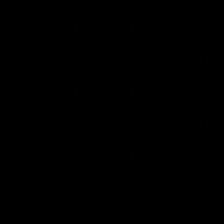

Image array shape: (224, 224, 3)
Min pixel value: 0
Max pixel value: 1


In [ ]:
from PIL import Image
import numpy as np
from IPython.display import display


# Access an example and its PIL image
ex = ds['train'][0]
print("Example:", ex)

# Display the PIL image
display(ex["pil_image"])

# Convert PIL image to NumPy array
image_array = np.array(ex["pil_image"])

# Display image array shape and pixel values
print("Image array shape:", image_array.shape)
print("Min pixel value:", np.min(image_array))
print("Max pixel value:", np.max(image_array))

In [ ]:
labels = ds['train'][0]['labels']
labels

'progressor'

In [ ]:
class_labels

ClassLabel(names=['nonprogressor', 'progressor'], id=None)

In [ ]:
class_labels.str2int(labels)

1

In [ ]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
ds['train']

Dataset({
    features: ['image_path', 'labels', 'pil_image'],
    num_rows: 3365
})

In [ ]:
ex

{'image_path': '/content/gdrive/MyDrive/Seminar/project/immune_310_project/dataset/JPG_RGB_224_224/train_validation_test/train/progressor/3105_rgb_image_img118_row1023_col1023_rgb_values_counter5970944.jpg',
 'labels': 'progressor',
 'pil_image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>}

In [ ]:
# DEBUG
ex = ds['train'][400]
# image = ex['pil_image']
image_path = ex['image_path']
pil_image = Image.open(image_path)
feature_extractor(pil_image, return_tensors='pt')

{'pixel_values': tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]])}

In [ ]:
# ONLY FOR DEBUG
# def process_example(example):
#   inputs = feature_extractor(example['pil_image'], return_tensors='pt')
#   inputs['labels'] = example['labels']
#   return inputs
def process_example(example):
  # image_path = example['image_path']
  # pil_image = Image.open(image_path)
  # np.array(example["pil_image"])
  feature_extractor(np.array(example["pil_image"]), return_tensors='pt')
  inputs = feature_extractor(pil_image, return_tensors='pt')
  inputs['labels'] = class_labels.str2int(example['labels'])
  return inputs

In [ ]:
in_example = process_example(ds['train'][0])
in_example

{'pixel_values': tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]]), 'labels': 1}

In [ ]:
type(in_example['pixel_values'])

torch.Tensor

In [ ]:
# feature_extractor([x for x in example_batch['pil_image']], return_tensors='pt')

In [ ]:
# prepared_ds={}
# def transform(example_batch):
#     # Take a list of PIL images and turn them to pixel values
#     inputs = feature_extractor([x for x in example_batch['pil_image']], return_tensors='pt')

#     # Don't forget to include the labels!
#     inputs['labels'] = example_batch['labels']
#     return inputs

# for val in ["train","validation","test"]:
#   prepared_ds[val] = ds[val].with_transform(transform)

prepared_ds={}
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([Image.open(x) for x in example_batch['image_path']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

for val in ["train","validation","test"]:
  prepared_ds[val] = ds[val].with_transform(transform)

In [ ]:
prepared_ds['train']

Dataset({
    features: ['image_path', 'labels', 'pil_image'],
    num_rows: 3365
})

In [ ]:
import torch

def collate_fn(batch):
  return {
        # 'pixel_values': torch.stack([x['pil_image'] for x in batch]),
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([class_labels.str2int(x['labels']) for x in batch])
    }

    # class_labels.str2int


In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

<ipython-input-25-3044fb6e3895>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
class_labels.names

['nonprogressor', 'progressor']

In [ ]:

# for CPU:
# !pip install transformers[torch]
# restart
# !pip install tensorboard

In [ ]:
from transformers import ViTForImageClassification

labels = class_labels.names #ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Generate a date-time string
from datetime import datetime
current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
current_datetime

'2023-08-12_21-19-00'

In [ ]:
tensorboard_log = os.path.join(rgb_images_path, "tensorboard",current_datetime)
os.makedirs(tensorboard_log,exist_ok=True)
tensorboard_log

'/content/gdrive/MyDrive/Seminar/project/immune_310_project/dataset/JPG_RGB_224_224/train_validation_test/tensorboard/2023-08-12_21-19-00'

In [ ]:
lr = 5e-5
num_train_epochs = 20
batch_size = 16
# evaluation_strategy = "epoch"
# optimizers
# callbacks
model_output_dir = os.path.join(rgb_images_path, "model_output_dir","lr_{}_epochs_{}_batch_size_{}".format(lr,num_train_epochs,batch_size))
os.makedirs(model_output_dir,exist_ok=True)
model_output_dir

'/content/gdrive/MyDrive/Seminar/project/immune_310_project/dataset/JPG_RGB_224_224/train_validation_test/model_output_dir/lr_5e-05_epochs_20_batch_size_16'

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir=model_output_dir,
  per_device_train_batch_size=batch_size,
  evaluation_strategy = "epoch",
  logging_strategy = "epoch",
  save_strategy = "epoch",
  num_train_epochs=num_train_epochs,
  save_steps=100,
  eval_steps = 50,
  logging_steps=10,
  learning_rate=lr,
  save_total_limit=5,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
  # fp16=False,  # Disable mixed precision training. The True had error issues
  fp16_opt_level="O2",  # Specify optimization level
  logging_dir=tensorboard_log, # Set the logging directory
)


In [ ]:
prepared_ds

{'train': Dataset({
     features: ['image_path', 'labels', 'pil_image'],
     num_rows: 3365
 }),
 'validation': Dataset({
     features: ['image_path', 'labels', 'pil_image'],
     num_rows: 615
 }),
 'test': Dataset({
     features: ['image_path', 'labels', 'pil_image'],
     num_rows: 616
 })}

In [ ]:
# type(prepared_ds['train']['pil_image'])

In [ ]:
from transformers import EarlyStoppingCallback, IntervalStrategy

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    callbacks = [EarlyStoppingCallback(early_stopping_patience=5)],
    tokenizer=feature_extractor,
)

In [ ]:
train_results = trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

In [ ]:
prepared_ds['test']

In [ ]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

In [ ]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'dcis-eila',
    "tags": ['image-classification'],
}

if training_args.push_to_hub:
    trainer.push_to_hub('🍻 cheers', **kwargs)
else:
    trainer.create_model_card(**kwargs)